In [1]:
%load_ext autoreload
%autoreload 2

In [278]:
import torch
import numpy as np
import torch.nn as nn

import sys
sys.path.append('../')


import pyroml as p
from pyroml.template.iris import IrisNet, IrisDataset, load_dataset

In [3]:
SEED = 42
p.seed_everything(SEED)

In [36]:
ds = load_dataset()
ds = ds.shuffle(seed=SEED)
tr_ds, ev_ds, te_ds = np.split(ds, [int(0.6 * len(ds)), int(0.7 * len(ds))])

tr_ds = IrisDataset(tr_ds)
ev_ds = IrisDataset(ev_ds)
te_ds = IrisDataset(te_ds)

In [124]:
class ScheduledIrisNet(IrisNet):
    def configure_optimizers(self, loop: "p.Loop"):
        tr = self.trainer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=tr.lr)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=tr.lr,
            total_steps=loop.total_steps,
            steps_per_epoch=loop.steps_per_epochs,
            epochs=tr.max_epochs,
            anneal_strategy="cos",
            cycle_momentum=False,
            div_factor=1e2,
            final_div_factor=0.05,
        )

In [125]:
model = ScheduledIrisNet()
model

ScheduledIrisNet(
  (module): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [126]:
import logging
trainer = p.Trainer(
    compile=True,
    loss=nn.CrossEntropyLoss(),
    max_epochs=12,
    batch_size=16,
    lr=0.005,
    evaluate=True,
    evaluate_every=12,
    wandb=False,
    dtype=torch.bfloat16,
    log_level=logging.INFO,
)

In [284]:
tr_tracker = trainer.fit(model, tr_ds, ev_ds)
tr_tracker.records

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The 
default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically 
infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an 
error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, 
you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=61888) 
is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:117: MissingStepKeyWarning: No metric key Step.METRIC_TARGET in 
output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.

,stage,epoch,step,acc,pre,rec,loss,epoch_acc,epoch_pre,epoch_rec,epoch_loss
0,validation,0,0,0.933333,0.933333,0.933333,0.170462,NaN,NaN,NaN,NaN
1,validation,0,1,NaN,NaN,NaN,NaN,0.933333,0.933333,0.933333,0.170462
2,train,0,0,1.000000,1.000000,1.000000,0.038585,NaN,NaN,NaN,NaN
3,train,0,1,1.000000,1.000000,1.000000,0.044439,NaN,NaN,NaN,NaN
4,train,0,2,1.000000,1.000000,1.000000,0.056452,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
91,train,11,68,0.979167,0.979167,0.979167,0.034630,NaN,NaN,NaN,NaN
92,train,11,69,0.968750,0.968750,0.968750,0.063120,NaN,NaN,NaN,NaN
93,train,11,70,0.975000,0.975000,0.975000,0.058233,NaN,NaN,NaN,NaN
94,train,11,71,0.966667,0.966667,0.966667,0.074027,NaN,NaN,NaN,NaN


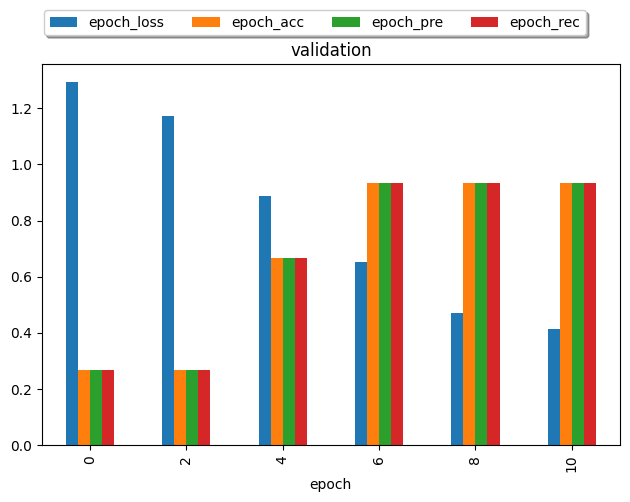

In [277]:
tr_tracker.plot(stage=p.Stage.VAL, epoch=True, kind='bar')

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:110: UserWarning: No metric in output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.
  warnings.warn(msg)

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:110: UserWarning: No metric in output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.
  warnings.warn(msg)

/home/edge/dev/py/pyro/pyroml/metrics/tracker.py:110: UserWarning: No metric in output, using Step.TARGET instead
If your model is used for classification, you likely want to output a Step.METRIC_TARGET key as well.
  warnings.warn(msg)

/home/edge/dev/py/pyro/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028


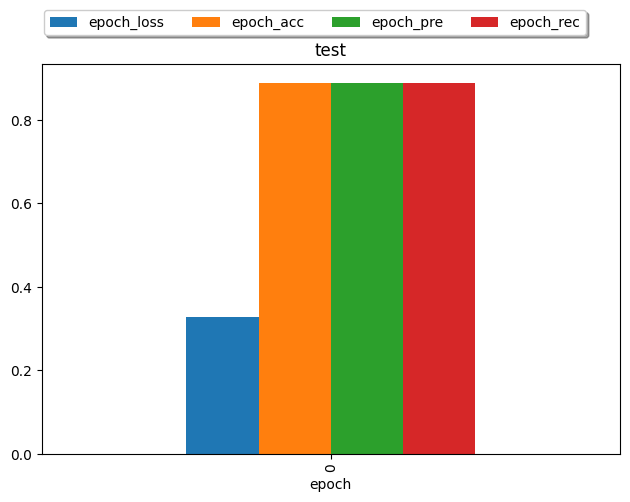

In [279]:
te_metrics = trainer.test(model, te_ds)
te_metrics.plot(epoch=True, kind="bar")